# Non-orthogonality of odor vectors

Illustrate that the background vectors and resulting mixture are non-negative and non-orthogonal; also compute the average dot product between two vectors with exponentially-distributed elements afterwise unit-normed. 

## Imports

In [25]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from time import perf_counter
import os, json, sys
if ".." not in sys.path:
    sys.path.insert(1, "..")
from os.path import join as pj

from modelfcts.average_sub import integrate_inhib_average_sub_skip

from modelfcts.ideal import (
    find_projector, 
    find_parallel_component, 
    ideal_linear_inhibitor, 
    compute_ideal_factor
)
from modelfcts.checktools import (
    analyze_pca_learning, 
    check_conc_samples_powerlaw_exp1
)
from modelfcts.backgrounds import (
    update_powerlaw_times_concs,
    sample_ss_conc_powerlaw,
    sample_ss_mixed_concs_powerlaw,
    generate_odorant
)
from utils.statistics import seed_from_gen
from modelfcts.distribs import (
    truncexp1_average,
    powerlaw_cutoff_inverse_transform
)
from utils.metrics import jaccard, l2_norm

### Aesthetic parameters

In [26]:
#plt.style.use(['dark_background'])
plt.rcParams["figure.figsize"] = (4.5, 3.0)
do_save_plots = True

### Initialization

In [39]:
# Initialize common simulation parameters
n_dimensions = 50  # Fly dimensions
n_components = 4  # Number of background odors

inhib_rates = [5e-5, 1e-5]  # alpha, beta  [0.00025, 0.00005]

# Simulation duration
duration = 360000.0
deltat = 1.0
n_chunks = 1
skp = 50 * int(1.0 / deltat)

# Common model options
activ_function = "identity"  # "ReLU"

# Background process
update_fct = update_powerlaw_times_concs

# Choose randomly generated background vectors
# This seed gave nicely spread out odors easier to learn 0xe329714605b83365e67b44ed7e001ec
# Another random seed: 0xb7bf767bbad297aeeee19d0ccdc3647e
rgen_meta = np.random.default_rng(seed=0x47cf767aaab807aeeee19d0cfdc3629c)
back_components = np.zeros([n_components, n_dimensions])
for i in range(n_components):
    back_components[i] = generate_odorant(n_dimensions, rgen_meta, lambda_in=0.1)
back_components = back_components / l2_norm(back_components).reshape(-1, 1)

# Seed for background simulation, to make sure all models are the same
simul_seed = seed_from_gen(rgen_meta)

# Turbulent background parameters: same rates and constants for all odors
back_params = [
    np.asarray([1.0] * n_components),        # whiff_tmins
    np.asarray([500.] * n_components),       # whiff_tmaxs
    np.asarray([1.0] * n_components),        # blank_tmins
    np.asarray([800.0] * n_components),      # blank_tmaxs
    np.asarray([0.6] * n_components),        # c0s
    np.asarray([0.5] * n_components),        # alphas
]

# Compute mean of independent underlying variables, 
# to determine the mean and target covariance of mixed variables
tblo, tbhi, twlo, twhi = back_params[2], back_params[3], back_params[0], back_params[1]
whiffprob = np.mean(1.0 / (1.0 + np.sqrt(tblo*tbhi/twlo/twhi)))
avg_whiff_conc = np.mean(truncexp1_average(*back_params[4:6]))
mean_conc = whiffprob * avg_whiff_conc  # average time in whiffs vs blanks * average whiff conc
print("Analytical mean conc:", mean_conc)
#print("Numerical mean conc:", mean_conc_empirical)

# Then add background odor vectors last to that list
back_params.append(back_components)

# Initial values of background process variables (t, c for each variable)
init_concs = sample_ss_conc_powerlaw(*back_params[:-1], size=1, rgen=rgen_meta)
init_times = powerlaw_cutoff_inverse_transform(
                rgen_meta.random(size=n_components), *back_params[2:4])
tc_init = np.stack([init_times, init_concs.squeeze()], axis=1)

# Initial background vector 
init_bkvec = tc_init[:, 1].dot(back_components)
# nus are first in the list of initial background params
init_back_list = [tc_init, init_bkvec]

Analytical mean conc: 0.17220708258109407


## Background process example

In [40]:
# Run a dense simulation to extract mixed concentrations for
# global correl_rho chosen above (0.7)
# Dummy initialization
avg_options = {"activ_fct": activ_function}
init_synapses_avg = np.zeros([1, n_dimensions])

sim_avg_res = integrate_inhib_average_sub_skip(
                init_synapses_avg, update_fct, init_back_list, 
                [], inhib_rates, back_params, duration, deltat,
                seed=simul_seed, noisetype="uniform", skp=1, **avg_options
)

_, bkser_avg, bkvecser_avg, _, _ = sim_avg_res
del sim_avg_res

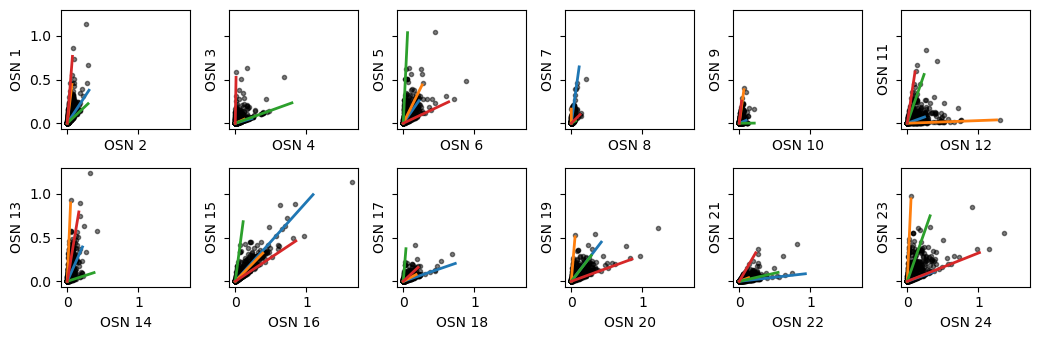

In [41]:
# Background vectors time series with mixed concentrations
tslice = slice(0, 50000, 100)
n_cols = 6
n_plots = n_dimensions // 4  # Only show first 24 OSNs
n_rows = n_plots // n_cols + min(1, n_plots % n_cols)
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
fig.set_size_inches(n_cols*1.75, n_rows*1.75)
for i in range(n_plots):
    ax = axes.flat[i]
    ax.scatter(bkvecser_avg[tslice, 2*i+1], bkvecser_avg[tslice, 2*i], 
               s=9, alpha=0.5, color="k")
    for j in range(n_components):
        ax.plot(*zip([0.0, 0.0], 3.0*back_components[j, 2*i:2*i+2:][::-1]), lw=2.0)
    ax.set(xlabel="OSN {}".format(2*i+2), ylabel="OSN {}".format(2*i+1))
for i in range(n_plots, n_rows*n_cols):
    axes.flat[i].set_axis_off()
fig.tight_layout()
if do_save_plots:
    fig.savefig(pj("..", "figures", "correlation", "osn_background_vectors.pdf"), 
               transparent=True, bbox_inches="tight")
plt.show()
plt.close()

# Average dot product between random odors
Generate a bunch of odors and bootstrap the average dot product

In [42]:
# Bootstrap by sampling s_i and s_j with replacement, computing s_i.dot(s_j)
n_samp = int(1e5)
samp_size = int(1e4)
n_boot = 10000
boot_dots = np.zeros(n_boot)

start_t = perf_counter()
odors = generate_odorant((n_samp, n_dimensions), rgen_meta)
odors = odors / l2_norm(odors, axis=1)[:, None]
for i in range(n_boot):
    od_choice_i = rgen_meta.choice(n_samp, size=samp_size, replace=True)
    od_choice_j = rgen_meta.choice(n_samp, size=samp_size, replace=True)
    odors_sample_i = odors[od_choice_i]
    odors_sample_j = odors[od_choice_j]
    dotprods = np.sum(odors_sample_i * odors_sample_j, axis=1)
    boot_dots[i] = np.mean(dotprods)
end_t = perf_counter()
print("Finished {} bootstrap repeats with {} samples each in {:.2f} s".format(
    n_boot, samp_size, end_t - start_t))

Finished 10000 bootstrap repeats with 10000 samples each in 19.34 s


In [43]:
mean_dot = np.mean(boot_dots)
vari_dot = np.var(boot_dots, ddof=1)  # unbiased estimator
print("Mean dot product:", mean_dot)
print("Standard dev.:", np.sqrt(vari_dot))

Mean dot product: 0.5166211994911646
Standard dev.: 0.0008240391399341594


In [44]:
# Compare to generating new odors every time
n_boot2 = n_boot // 2
samp_size2 = samp_size // 2
boot_dots2 = np.zeros(n_boot2)
start_t = perf_counter()
for i in range(n_boot // 2):
    odors_sample_i = generate_odorant((samp_size2, n_dimensions), rgen_meta)
    odors_sample_i = odors_sample_i / l2_norm(odors_sample_i, axis=1)[:, None]
    odors_sample_j = generate_odorant((samp_size2, n_dimensions), rgen_meta)
    odors_sample_j = odors_sample_j / l2_norm(odors_sample_j, axis=1)[:, None]
    dotprods = np.sum(odors_sample_i * odors_sample_j, axis=1)
    boot_dots2[i] = np.mean(dotprods)
end_t = perf_counter()
print("Finished {} bootstrap repeats with {} samples each in {:.2f} s".format(
    n_boot2, samp_size2, end_t - start_t))

Finished 5000 bootstrap repeats with 5000 samples each in 15.68 s


In [45]:
mean_dot2 = np.mean(boot_dots2)
vari_dot2 = np.var(boot_dots2, ddof=1)  # unbiased estimator
print("Mean dot product:", mean_dot2)
print("Standard dev.:", np.sqrt(vari_dot2))

Mean dot product: 0.5162791253319848
Standard dev.: 0.0011742262647729464
